# Identify and visualize non-overlapping clades

Given an auspice tree, a start date, and an end date, can I partition a tree into non-overlapping clades, annotate all nodes in the clades by their grouping, and visualize the results?

## Import and configure code

In [5]:
import sys
sys.path.insert(0, "../../dist/augur")

In [6]:
import json
import matplotlib as mpl
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np

from base.io_util import json_to_tree

%matplotlib inline

In [7]:
def plot_tree(tree, color_by_trait, initial_branch_width, tip_size, figure_name=None):
    """Plot a BioPython Phylo tree in the BALTIC-style.
    """
    # Plot H3N2 tree in BALTIC style from Bio.Phylo tree.
    mpl.rcParams['savefig.dpi'] = 120
    mpl.rcParams['figure.dpi'] = 100

    mpl.rcParams['font.weight']=300
    mpl.rcParams['axes.labelweight']=300
    mpl.rcParams['font.size']=14

    yvalues = [node.yvalue for node in tree.find_clades()]
    y_span = max(yvalues)
    y_unit = y_span / float(len(yvalues))

    # Setup colors.
    trait_name = color_by_trait
    traits = [k.attr.get(trait_name) for k in tree.find_clades()
              if k.attr.get(trait_name)]
    norm = mpl.colors.Normalize(min(traits), max(traits))
    cmap = mpl.cm.viridis

    #
    # Setup the figure grid.
    #

    fig = plt.figure(figsize=(8, 6), facecolor='w')
    gs = gridspec.GridSpec(2, 1, height_ratios=[14, 1], width_ratios=[1], hspace=0.1, wspace=0.1)
    ax = fig.add_subplot(gs[0])
    colorbar_ax = fig.add_subplot(gs[1])

    L=len([k for k in tree.find_clades() if k.is_terminal()])

    # Setup arrays for tip and internal node coordinates.
    tip_circles_x = []
    tip_circles_y = []
    tip_circles_color = []
    tip_circle_sizes = []
    node_circles_x = []
    node_circles_y = []
    node_circles_color = []
    node_line_widths = []
    node_line_segments = []
    node_line_colors = []
    branch_line_segments = []
    branch_line_widths = []
    branch_line_colors = []
    branch_line_labels = []

    for k in tree.find_clades(): ## iterate over objects in tree
        x=k.attr["num_date"] ## or from x position determined earlier
        y=k.yvalue ## get y position from .drawTree that was run earlier, but could be anything else

        if k.up is None:
            xp = None
        else:
            xp=k.up.attr["num_date"] ## get x position of current object's parent

        if x==None: ## matplotlib won't plot Nones, like root
            x=0.0
        if xp==None:
            xp=x

        c = (0.6, 0.6, 0.6)
        if k.attr.has_key(trait_name):
            c = cmap(norm(k.attr[trait_name]))

        branchWidth=2
        if k.is_terminal(): ## if leaf...
            s = tip_size ## tip size can be fixed

            tip_circle_sizes.append(s)
            tip_circles_x.append(x)
            tip_circles_y.append(y)
            tip_circles_color.append(c)
        else: ## if node...
            k_leaves = [child
                        for child in k.find_clades()
                        if child.is_terminal()]

            # Scale branch widths by the number of tips.
            branchWidth += initial_branch_width * len(k_leaves) / float(L)

            if len(k.clades)==1:
                node_circles_x.append(x)
                node_circles_y.append(y)
                node_circles_color.append(c)

            ax.plot([x,x],[k.clades[-1].yvalue, k.clades[0].yvalue], lw=branchWidth, color=c, ls='-', zorder=9, solid_capstyle='round')

        branch_line_segments.append([(xp, y), (x, y)])
        branch_line_widths.append(branchWidth)
        branch_line_colors.append(c)

    branch_lc = LineCollection(branch_line_segments, zorder=9)
    branch_lc.set_color(branch_line_colors)
    branch_lc.set_linewidth(branch_line_widths)
    branch_lc.set_label(branch_line_labels)
    branch_lc.set_linestyle("-")
    ax.add_collection(branch_lc)

    # Add circles for tips and internal nodes.
    tip_circle_sizes = np.array(tip_circle_sizes)
    ax.scatter(tip_circles_x, tip_circles_y, s=tip_circle_sizes, facecolor=tip_circles_color, edgecolor='none',zorder=11) ## plot circle for every tip
    ax.scatter(tip_circles_x, tip_circles_y, s=tip_circle_sizes*2, facecolor='k', edgecolor='none', zorder=10) ## plot black circle underneath
    ax.scatter(node_circles_x, node_circles_y, facecolor=node_circles_color, s=50, edgecolor='none', zorder=10, lw=2, marker='|') ## mark every node in the tree to highlight that it's a multitype tree

    #ax.set_ylim(-10, y_span - 300)

    ax.spines['top'].set_visible(False) ## no axes
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ax.grid(axis='x',ls='-',color='grey')
    ax.tick_params(axis='y',size=0)
    ax.set_yticklabels([])

    cb1 = mpl.colorbar.ColorbarBase(
        colorbar_ax,
        cmap=cmap,
        norm=norm,
        orientation='horizontal'
    )
    cb1.set_label(color_by_trait)

    gs.tight_layout(fig)
    
    if figure_name:
        plt.savefig(figure_name)

## Load an auspice tree

In [24]:
with open("flu_h3n2_ha_2016-2018y_1v_0_tree.json", "r") as fh:
    tree_json = json.load(fh)

tree = json_to_tree(tree_json)

In [25]:
tree

Clade(branch_length=0, clade=363, name='NODE_0000204', numdate=2011.46615429, strain='NODE_0000204', yvalue=189.731412867)

## Identify clades from a given start date

The general idea for this works as follows for each node in the tree:

  1. If the node's inferred date is greater than or equal to the start date, select it.
  1. If the selected node's parent does not have a clade group and is not a tip, increment the current group number and assign the new number to the node.
  1. Else, assign the parent's group number to the node.
  
This should result in all nodes sampled prior to the start date not having a clade group and only monophyletic groups sampled after the start date being assigned clade groups.

In [69]:
start_date = 2015.0

In [70]:
# Reset attribute on nodes.
for clade in tree.find_clades():
    if "clade_group" in clade.attr:
        del clade.attr["clade_group"]

clade_group = 0
clades = {}
for clade in tree.find_clades():
    if clade.attr["num_date"] >= start_date:
        if "clade_group" in clade.up.attr:
            clade.attr["clade_group"] = clade.up.attr["clade_group"]
        elif not clade.is_terminal():
            clade_group += 1
            clade.attr["clade_group"] = clade_group
            clades[clade_group] = clade

In [71]:
clade_group

6

In [72]:
total_tips = 0
for clade in clades.values():
    clade_tips = len(clade.get_terminals())
    total_tips += clade_tips
    print(clade_tips)

2
5
10
29
37
98


In [73]:
total_tips

181

In [74]:
len([tip for tip in tree.get_terminals() if tip.attr["num_date"] >= start_date])

188

In [77]:
clades

{1: Clade(branch_length=0.0177052738298, clade=15, name='NODE_0000196', numdate=2017.79906493, strain='NODE_0000196', yvalue=193.5),
 2: Clade(branch_length=0.00647040486293, clade=28, name='NODE_0000198', numdate=2015.1956535, strain='NODE_0000198', yvalue=188.75),
 3: Clade(branch_length=0.0117967337008, clade=53, name='NODE_0000174', numdate=2016.81917366, strain='NODE_0000174', yvalue=180.8125),
 4: Clade(branch_length=0.0100182812372, clade=107, name='NODE_0000141', numdate=2016.34533237, strain='NODE_0000141', yvalue=162.015625),
 5: Clade(branch_length=0.0135516314033, clade=177, name='NODE_0000098', numdate=2016.35510695, strain='NODE_0000098', yvalue=131.174316406),
 6: Clade(branch_length=0.0129577453343, clade=355, name='NODE_0000095', numdate=2015.31292841, strain='NODE_0000095', yvalue=87.3173775673)}

## Visualize clades

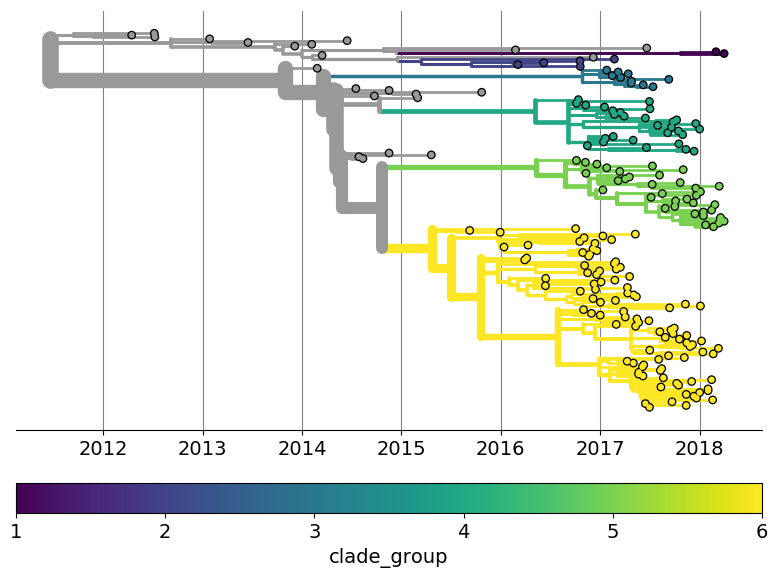

In [75]:
plot_tree(tree, "clade_group", 10, 20)

In [76]:
min([clade.attr["num_date"] for clade in tree.find_clades() if "clade_group" in clade.attr])

2015.1956535034708